In [ ]:
!pip install yfinance

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

In [150]:
forex_data_1 = yf.download('EURUSD=X', start='2020-01-01', end='2021-12-31')

[*********************100%***********************]  1 of 1 completed


In [151]:
#Removing unnecessary columns
df=forex_data_1.drop(['Open', 'High', 'Low', 'Close', 'Volume'],axis=1) 
df.rename(columns={'Adj Close': 'eur'},inplace=True) 
df.head(2)

,eur
Date,
2020-01-01,1.122083
2020-01-02,1.122083


Add extra features

In [152]:
def RSI( prices, n=14):
  deltas = np.diff(prices)
  seed = deltas[:n+1]
  up = seed[seed >= 0].sum()/n
  down = -seed[seed < 0].sum()/n
  rs = up/down
  rsi = np.zeros_like(prices)
  rsi[:n] = 100. - 100./(1.+rs)

  for i in range(n, len(prices)):
      delta = deltas[i-1]  # The diff is 1 shorter

      if delta > 0:
          upval = delta
          downval = 0.
      else:
          upval = 0.
          downval = -delta

      up = (up*(n-1) + upval)/n
      down = (down*(n-1) + downval)/n

      rs = up/down
      rsi[i] = 100. - 100./(1.+rs)

  return rsi



In [153]:
rsi = RSI(prices=df['eur'].to_list(),n=14)


In [154]:
df['rsi'] = rsi

In [155]:
ytrain=[]
ss2 = MinMaxScaler(feature_range=(0,1))
train2 = ss2.fit_transform(np.array(df['eur']).reshape(-1,1))
for i in range(60,len(train2)):
  ytrain.append(train2[i])

In [156]:
#Scaling the values between 0 to 1
ss= MinMaxScaler(feature_range=(0,1))
train = ss.fit_transform(np.array(df))

In [157]:
# Feature selection
xtrain=[]


for i in range(60,len(train)):
    xtrain.append([train[i-60:i,0],train[i-60:i,1]])
    #ytrain.append(train[i,0])

xtrain, ytrain = np.array(xtrain), np.array(ytrain)

In [158]:
xtrain.shape

(463, 2, 60)

In [159]:
#Reshaping the train data to make it as input for LTSM layer input_shape(batchzise,timesteps,input_dim)
xtrain= np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[2],xtrain.shape[1]))

In [160]:
xtrain.shape 

(463, 60, 2)

### Build an GRU Model

In [161]:
from keras.models import Sequential
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout

In [162]:
#initialisizng the model 
regression= Sequential()

regression.add(GRU(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1],2)))
regression.add(Dropout(0.2))

regression.add(GRU(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

regression.add(GRU(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

regression.add(GRU(units=50,kernel_initializer='glorot_uniform'))
regression.add(Dropout(0.2))
regression.add(Dense(units=1))

regression.compile(optimizer='adam',loss='mean_squared_error')

#fitting the network
regression.fit(xtrain,ytrain,batch_size=30,epochs=500)

Epoch 1/500
16/16 [==============================] - 9s 115ms/step - loss: 0.1122
Epoch 2/500
16/16 [==============================] - 2s 117ms/step - loss: 0.0614
Epoch 3/500
16/16 [==============================] - 2s 115ms/step - loss: 0.0578
Epoch 4/500
16/16 [==============================] - 2s 115ms/step - loss: 0.0571
Epoch 5/500
16/16 [==============================] - 2s 115ms/step - loss: 0.0577
Epoch 6/500
16/16 [==============================] - 2s 115ms/step - loss: 0.0553
Epoch 7/500
16/16 [==============================] - 2s 116ms/step - loss: 0.0521
Epoch 8/500
16/16 [==============================] - 2s 116ms/step - loss: 0.0530
Epoch 9/500
16/16 [==============================] - 2s 116ms/step - loss: 0.0541
Epoch 10/500
16/16 [==============================] - 2s 117ms/step - loss: 0.0526
Epoch 11/500
16/16 [==============================] - 2s 115ms/step - loss: 0.0494
Epoch 12/500
16/16 [==============================] - 2s 117ms/step - loss: 0.0536
Epoch 13/500


In [163]:
#regression.save('model.h5')

In [164]:
test_df = yf.download('EURUSD=X', start='2022-01-01', end='2022-06-30')

[*********************100%***********************]  1 of 1 completed


In [165]:
test_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,1.137385,1.137592,1.128541,1.137346,1.137346,0
2022-01-04,1.130199,1.132300,1.127345,1.130224,1.130224,0
2022-01-05,1.128541,1.134559,1.127764,1.128363,1.128363,0
2022-01-06,1.131222,1.133067,1.128554,1.131350,1.131350,0
2022-01-07,1.129586,1.135976,1.129050,1.129688,1.129688,0


In [166]:
test = pd.DataFrame()

In [167]:
test['eur'] = test_df['Adj Close']

In [168]:
test.shape[0]

129

In [169]:
total= pd.concat([df['eur'],test['eur']],axis=0)

In [170]:
df_total = pd.DataFrame()
df_total['eur'] = total.to_list()


In [171]:
df_total.index = total.index

In [172]:
df_total['rsi'] = RSI(prices=total.to_list(),n=14)

In [173]:
df_total = df_total.dropna()

In [174]:
total = np.array(df_total)

In [175]:
test_input = total[len(total)-len(test)-60:]
#test_input= test_input.reshape(-1,1) # reshaping it to get it transformed
test_input= ss.transform(test_input)

In [176]:
xtest= []
for i in range(60,80):
    xtest.append([test_input[i-60:i,0],test_input[i-60:i,1]]) #creating input for lstm prediction

In [177]:
xtest= np.array(xtest)

In [178]:
xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[2],xtest.shape[1]))

In [179]:
#xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
predicted_value= regression.predict(xtest)

In [180]:
predicted_value2= ss2.inverse_transform(predicted_value)

### Plot the Data

In [181]:
test_actual = np.array(test[0:20]['eur'])

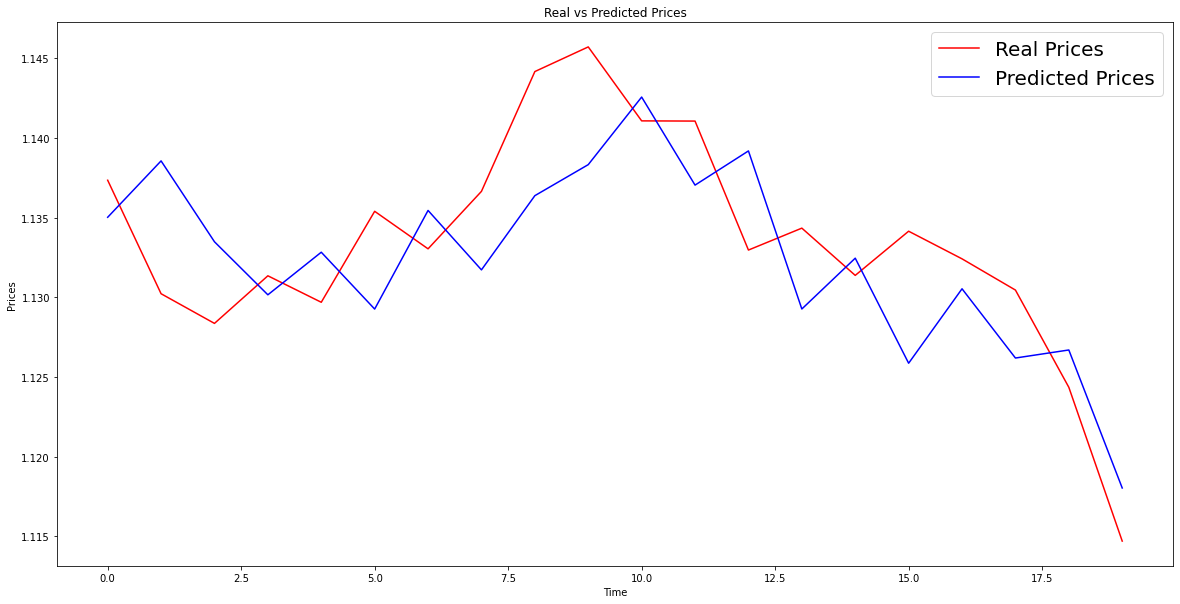

In [182]:
plt.figure(figsize=(20,10))
plt.plot(test_actual,'red',label='Real Prices')
plt.plot(predicted_value2,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)

In [183]:
from sklearn.metrics import r2_score
r2_score(test_actual, predicted_value2)

0.46887732308095587

In [184]:
#-1.9447788078646049 - No scaling of yvalues
#0.100 : with scaling of yvalues